In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import os

In [5]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning,module='bs4')

In [6]:
import nltk

ModuleNotFoundError: No module named 'nltk'

In [7]:
!pip install nltk

     |████████████████████████████████| 1.5MB 38kB/s eta 0:00:014
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=bdf20a231bb0c9c37e940fb79e8a9b5e5f24f9cc42dca22b5351203b30194e13
  Stored in directory: /Users/lidianxiang/Library/Caches/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk


In [8]:
import nltk

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
!pip install bs4

     |████████████████████████████████| 102kB 35kB/s ta 0:00:011
  Created wheel for bs4: filename=bs4-0.0.1-cp36-none-any.whl size=1274 sha256=d20f9bb49656020f94d0158b35613b5b3de65cd80eed68b63344cbb6b8d7e0dd
  Stored in directory: /Users/lidianxiang/Library/Caches/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [12]:
from bs4 import BeautifulSoup
import re

from tqdm import tqdm

In [13]:
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed_seed

In [34]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential


set_random_seed(123)
random.seed(123)

In [17]:
# load dataset
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [18]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [19]:
train.shape

(156060, 4)

In [20]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [21]:
test.shape

(66292, 3)

In [22]:
# 特征前处理，清理评论，并分词，词干还原
def clean_sentences(df):
    reviews = []
    
    for sent in tqdm(df["Phrase"]):
        # remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        # remove non-alphaetic characters
        review_text = re.sub("[^a-zA-Z]"," ",review_text)
        
        # tokenizer the sentences
        words = word_tokenize(review_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
    return reviews

In [23]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

100%|██████████| 66292/66292 [00:22<00:00, 2947.99it/s]


In [24]:
print(len(train_sentences))

156060


In [25]:
print(len(test_sentences))

66292


In [26]:
# one-hot编码映射
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [27]:
# split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [29]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)
    
    if (len_max< len(sent)):
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 568798.88it/s]

13737
48


In [31]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test,maxlen=len_max)

print(X_train.shape, X_val.shape, X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [32]:
early_stopping = EarlyStopping(min_delta=0.001, mode='max', monitor='val_acc', patience=2)

callback = [early_stopping]

In [39]:
# model = Sequential()
# model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
# model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
# model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))
# model.add(Dense(100,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes,activation='softmax'))
# model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrices=['accuracy'])
# model.summary()

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 300)           4121100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 4,397,161
Trainable params: 4,397,161
Non-trainable params: 0
_________________________________________________________________


In [40]:
# fit the model
# history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=6, batch_size=256, 
#                     verbose=1,callbacks=callback)
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 141s 1ms/step - loss: 0.9994 - acc: 0.5972 - val_loss: 0.8482 - val_acc: 0.6527
Epoch 2/6
124848/124848 [==============================] - 137s 1ms/step - loss: 0.8069 - acc: 0.6693 - val_loss: 0.8037 - val_acc: 0.6693
Epoch 3/6
124848/124848 [==============================] - 138s 1ms/step - loss: 0.7369 - acc: 0.6920 - val_loss: 0.8056 - val_acc: 0.6723
Epoch 4/6
124848/124848 [==============================] - 137s 1ms/step - loss: 0.6973 - acc: 0.7080 - val_loss: 0.8216 - val_acc: 0.6704
Epoch 5/6
124848/124848 [==============================] - 137s 1ms/step - loss: 0.6706 - acc: 0.7177 - val_loss: 0.8622 - val_acc: 0.6729


In [41]:
import matplotlib.pyplot as plt

In [42]:
epoch_count = range(1, len(history.history['loss']) + 1)

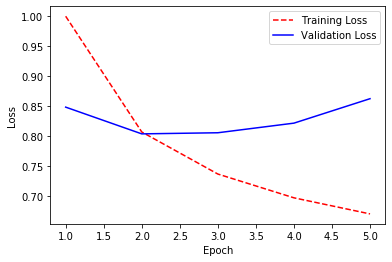

In [43]:
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [44]:
# submission
y_pred = model.predict_classes(X_test)

sub_file = pd.read_csv('sampleSubmission.csv', sep=',')
sub_file.Sentiment = y_pred
sub_file.to_csv('Submission_keras.csv', index=False)